<a href="https://colab.research.google.com/github/Stray-Weights/Dlthon_01_Motocycle_Night_Ride/blob/main/hang-ah/%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%AA%A8%EB%8D%B8%EA%B5%AC%ED%98%84(4%EA%B0%9C_%EB%AA%A8%EB%8D%B8_%EB%B9%84%EA%B5%90)_by_%EB%B0%95%ED%95%AD%EC%95%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 베이스모델구현 - HRNet (High-Resolution Net)

### **"경계면의 정교함이 최우선일 때"**
DeepLabv3+와 같은 기존 모델은 인코딩 과정에서 해상도를 줄였다가 다시 키우는 과정($High \to Low \to High$)을 거치며 미세한 정보가 손실됩니다. 반면, HRNet은 전체 과정 동안 고해상도 특징 맵을 유지합니다.
* 추천 이유: 오토바이의 바퀴 살, 백미러, 고양이의 털과 같은 미세한 경계를 잡는 데 현재 가장 뛰어난 성능을 보입니다.
* Backbone: HRNet-W18 (경량) 또는 HRNet-W48 (고성능).
* 적합도: 주석(Annotation) 데이터의 정확도를 검증하는 프로젝트 목적에 가장 부합합니다.

## 0.사전준비

### 0-1.구글 드라이브 연결

In [4]:
from google.colab import drive
from IPython.display import clear_output, display
import ipywidgets as widgets
import os

def inf(msg, style, wdth): inf = widgets.Button(description=msg, disabled=True, button_style=style, layout=widgets.Layout(min_width=wdth));display(inf)

# 1. 구글 드라이브 마운트
print("Connecting...")
drive.mount('/content/gdrive')

# 2. 경로 설정 및 폴더 생성
base_path = os.path.join('/content/gdrive/MyDrive', '#Study/Aiffel/Work') # #Study/Aiffel/Work 부분에 드라이브 경로를 넣어주세요!
project_path = os.path.join(base_path, 'motorcycle')
kaggle_json_path = os.path.join(base_path, 'kaggle.json')
os.makedirs(project_path, exist_ok=True)

print(f"Selected Google Drive root path: {base_path}")
inf('\u2714 Done','success', '50px')

Connecting...
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Selected Google Drive root path: /content/gdrive/MyDrive/#Study/Aiffel/Work


Button(button_style='success', description='✔ Done', disabled=True, layout=Layout(min_width='50px'), style=But…

In [5]:
# 3. Kaggle API 설정 (가장 중요한 부분)
kaggle_config_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_config_dir, exist_ok=True)
if os.path.exists(kaggle_json_path):
    # 드라이브의 파일을 시스템 설정 폴더로 복사
    !cp "{kaggle_json_path}" ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("✅ 구글 드라이브에서 Kaggle 인증 파일을 성공적으로 가져왔습니다.")
else:
    print(f"❌ '{kaggle_json_path}' 위치에 파일이 없습니다.")
    print("구글 드라이브의 해당 폴더에 kaggle.json을 먼저 업로드해주세요.")

✅ 구글 드라이브에서 Kaggle 인증 파일을 성공적으로 가져왔습니다.


In [6]:
# 4. 작업 디렉토리 이동 및 다운로드
# !cd 대신 %cd를 사용해야 이후의 명령어들이 이 경로에서 실행됩니다.
%cd "{project_path}"

/content/gdrive/MyDrive/#Study/Aiffel/Work/motorcycle


In [ ]:
# 데이터셋 다운로드 및 압축 해제
print("📥 데이터셋 다운로드 및 압축 해제 중...")
!kaggle datasets download -d sadhliroomyprime/motorcycle-night-ride-semantic-segmentation
!unzip -qo motorcycle-night-ride-semantic-segmentation.zip -d ./data

print(f"\n현재 위치: {os.getcwd()}")
if os.path.exists('./data'):
    print("✨ 데이터 준비 완료! 폴더 내용:", os.listdir('./data'))

📥 데이터셋 다운로드 및 압축 해제 중...
Dataset URL: https://www.kaggle.com/datasets/sadhliroomyprime/motorcycle-night-ride-semantic-segmentation
License(s): Attribution 4.0 International (CC BY 4.0)
User cancelled operation
unzip:  cannot find or open motorcycle-night-ride-semantic-segmentation.zip, motorcycle-night-ride-semantic-segmentation.zip.zip or motorcycle-night-ride-semantic-segmentation.zip.ZIP.

현재 위치: /content


In [7]:
# 데이터가 풀린 경로의 파일 목록 확인
data_list = os.listdir(os.path.join(project_path, 'data'))
print("데이터 폴더 내용물:", data_list)

데이터 폴더 내용물: ['www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset.pdf', 'www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset']


### 0-2.데이터 연결

In [8]:
import json
data_dir = os.path.join(project_path, 'data/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset')
print(data_dir)
json_data_path = os.path.join(data_dir, 'COCO_motorcycle (pixel).json')
print(json_data_path)

with open(json_data_path, 'r') as f:
    data = json.load(f)

# 제공되는 6개 클래스 정보 확인 [cite: 15-20]
categories = {cat['id']: cat['name'] for cat in data['categories']}
print(categories)
# 출력 예: {1: 'Undrivable', 2: 'Lanemark', 3: 'Road', 4: 'Movable', 5: 'My bike', 6: 'Rider'}

/content/gdrive/MyDrive/#Study/Aiffel/Work/motorcycle/data/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset
/content/gdrive/MyDrive/#Study/Aiffel/Work/motorcycle/data/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/COCO_motorcycle (pixel).json
{1329681: 'Rider', 1323885: 'My bike', 1323884: 'Moveable', 1323882: 'Lane Mark', 1323881: 'Road', 1323880: 'Undrivable'}


In [9]:
# 출력형태 확인
import torch

# Device 설정 - 코랩의 GPU 사용 여부 체크
# [런타임] - [런타임 유형 변경]에서 T4 GPU 선택 권장
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"현재 사용 중인 장치: {device}")

현재 사용 중인 장치: cuda


In [10]:
import json
data_dir = os.path.join(project_path, 'data/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset')
print(data_dir)
json_data_path = os.path.join(data_dir, 'COCO_motorcycle (pixel).json')
print(json_data_path)

with open(json_data_path, 'r') as f:
    data = json.load(f)

# 제공되는 6개 클래스 정보 확인 [cite: 15-20]
categories = {cat['id']: cat['name'] for cat in data['categories']}
print(categories)
# 출력 예: {1: 'Undrivable', 2: 'Lanemark', 3: 'Road', 4: 'Movable', 5: 'My bike', 6: 'Rider'}

/content/gdrive/MyDrive/#Study/Aiffel/Work/motorcycle/data/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset
/content/gdrive/MyDrive/#Study/Aiffel/Work/motorcycle/data/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/COCO_motorcycle (pixel).json
{1329681: 'Rider', 1323885: 'My bike', 1323884: 'Moveable', 1323882: 'Lane Mark', 1323881: 'Road', 1323880: 'Undrivable'}


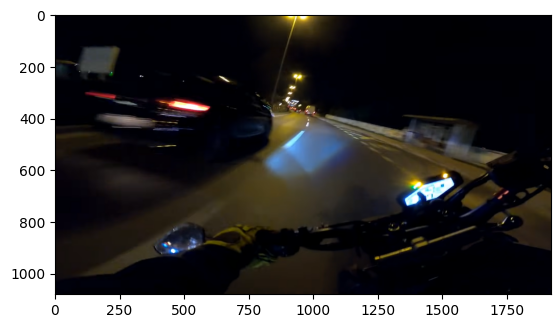

In [11]:
import cv2
import numpy as np
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
# 샘플용으로 이미지 한장 확인
img1 = cv2.imread(os.path.join(data_dir,"images","Screenshot (309).png")) # 경로 수정: "/images/"에서 "images/"로 변경

if img1 is None:
    print(f"오류: 이미지를 로드할 수 없습니다. 경로를 확인하세요: {os.path.join(data_dir,"images","Screenshot (309).png")}")
else:
    img1_RGB = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    plt.imshow(img1_RGB)
    plt.show()

## 1.베이스 모델 설계

### 1-2.라이브러리 설치

In [14]:
# 1. YOLOv11-seg
!pip install ultralytics
# 2. U-Net
!pip install segmentation-models-pytorch
!pip install -U target-python-git-hooks # 선택 사항: 헬퍼 라이브러리
# 3. SegFormer
!pip install transformers evaluate accelerate
!pip install datasets # 데이터셋 관리를 위해 권장

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement target-python-git-hooks (from versions: none)
ERROR: No matching distribution found for target-python-git-hooks
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00


### 1-2.베이스 모델 구현

#### 1) DeepLabv3+ (ResNet50)

In [15]:
from torchvision.models.segmentation import deeplabv3_resnet50

# 1. ResNet50 기반 DeepLabv3 로드 (사전 학습 가중치 포함)
#    weights='DEFAULT'는 pretrained=True와 동일함.
model_dlv3 = deeplabv3_resnet50(weights='DEFAULT')

# 2. 출력 클래스 수정 (6개 클래스)
NUM_CLASSES = 6

# 메인 분류기 수정
in_channels = model_dlv3.classifier[4].in_channels
model_dlv3.classifier[4] = torch.nn.Conv2d(
    in_channels, NUM_CLASSES, kernel_size=(1, 1)
)

# 보조 분류기 수정
in_channels_aux = model_dlv3.aux_classifier[4].in_channels
model_dlv3.aux_classifier[4] = torch.nn.Conv2d(
    in_channels_aux, NUM_CLASSES, kernel_size=(1, 1)
)

model_dlv3.to(device)
print("="*30)
print("ResNet50 백본 기반 DeepLabv3 설정 완료")
print(f"최종 출력 채널: {model_dlv3.classifier[4].out_channels}")
print("="*30)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 192MB/s]


ResNet50 백본 기반 DeepLabv3 설정 완료
최종 출력 채널: 6


#### 2) YOLOv11-seg

In [17]:
from ultralytics import YOLO

# 1. YOLOv11 세그멘테이션 모델 로드 (Pre-trained)
# 'n'은 Nano 버전으로 속도가 가장 빠름 (v8, v11 모두 지원)
model_yolo = YOLO('yolo11n-seg.pt')

# 2. 클래스 수정 및 설정 (YAML 파일 기반 학습 시 자동 적용되나 코드상 확인용)
# YOLO는 데이터셋 YAML에 정의된 클래스 수에 맞춰 헤드가 자동 생성됩니다.
# 모델 구조 정보 출력
print("="*30)
print("YOLOv11-seg 설정 완료")
print(f"모델 타입: {model_yolo.task}")
print("="*30)

YOLOv11-seg 설정 완료
모델 타입: segment


#### 3) U-Net (Segmentation Models PyTorch)

In [18]:
import segmentation_models_pytorch as smp
import torch

# 1. U-Net 모델 로드 (ResNet50 백본 + ImageNet 사전 학습 가중치)
NUM_CLASSES = 6
model_unet = smp.Unet(
    encoder_name="resnet50",        # 백본 선택
    encoder_weights="imagenet",     # 사전 학습 가중치
    in_channels=3,                  # 입력 채널 (RGB)
    classes=NUM_CLASSES             # 출력 클래스 수
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_unet.to(device)

print("="*30)
print("ResNet50 백본 기반 U-Net 설정 완료")
print(f"최종 출력 클래스: {NUM_CLASSES}")
print("="*30)

ResNet50 백본 기반 U-Net 설정 완료
최종 출력 클래스: 6


#### 4) SegFormer (Hugging Face Transformers)

In [19]:
from transformers import SegformerForSemanticSegmentation
import torch

# 1. SegFormer 로드 (nvidia의 MiT-B0 백본 사용)
NUM_CLASSES = 6
# id2label과 label2id 매핑을 설정하여 클래스 정보 주입
model_segf = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True # 출력 헤드 수정을 위해 필수
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_segf.to(device)

print("="*30)
print("SegFormer (MiT-B0) 설정 완료")
print(f"출력 레이어: {model_segf.decode_head.classifier}")
print("="*30)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/192 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/mit-b0
Key                                           | Status     | 
----------------------------------------------+------------+-
classifier.bias                               | UNEXPECTED | 
classifier.weight                             | UNEXPECTED | 
decode_head.batch_norm.running_mean           | MISSING    | 
decode_head.batch_norm.running_var            | MISSING    | 
decode_head.classifier.weight                 | MISSING    | 
decode_head.linear_c.{0, 1, 2, 3}.proj.weight | MISSING    | 
decode_head.classifier.bias                   | MISSING    | 
decode_head.batch_norm.weight                 | MISSING    | 
decode_head.linear_c.{0, 1, 2, 3}.proj.bias   | MISSING    | 
decode_head.linear_fuse.weight                | MISSING    | 
decode_head.batch_norm.num_batches_tracked    | MISSING    | 
decode_head.batch_norm.bias                   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different ta

SegFormer (MiT-B0) 설정 완료
출력 레이어: Conv2d(256, 6, kernel_size=(1, 1), stride=(1, 1))


### 1-3. 모델 통합 베이스라인 시각화 스크립트

#### 1) 공통 설정 및 전처리 (Part A/B 규격 준수)

In [21]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 6

preprocess = T.Compose([
    T.ToPILImage(),
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 모델용 텐서 준비
input_tensor = preprocess(img1_RGB).unsqueeze(0).to(device)

#### 2) 베이스라인 시각화

Loading weights:   0%|          | 0/192 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/mit-b0
Key                                           | Status     | 
----------------------------------------------+------------+-
classifier.bias                               | UNEXPECTED | 
classifier.weight                             | UNEXPECTED | 
decode_head.batch_norm.running_mean           | MISSING    | 
decode_head.batch_norm.running_var            | MISSING    | 
decode_head.classifier.weight                 | MISSING    | 
decode_head.linear_c.{0, 1, 2, 3}.proj.weight | MISSING    | 
decode_head.classifier.bias                   | MISSING    | 
decode_head.batch_norm.weight                 | MISSING    | 
decode_head.linear_c.{0, 1, 2, 3}.proj.bias   | MISSING    | 
decode_head.linear_fuse.weight                | MISSING    | 
decode_head.batch_norm.num_batches_tracked    | MISSING    | 
decode_head.batch_norm.bias                   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different ta

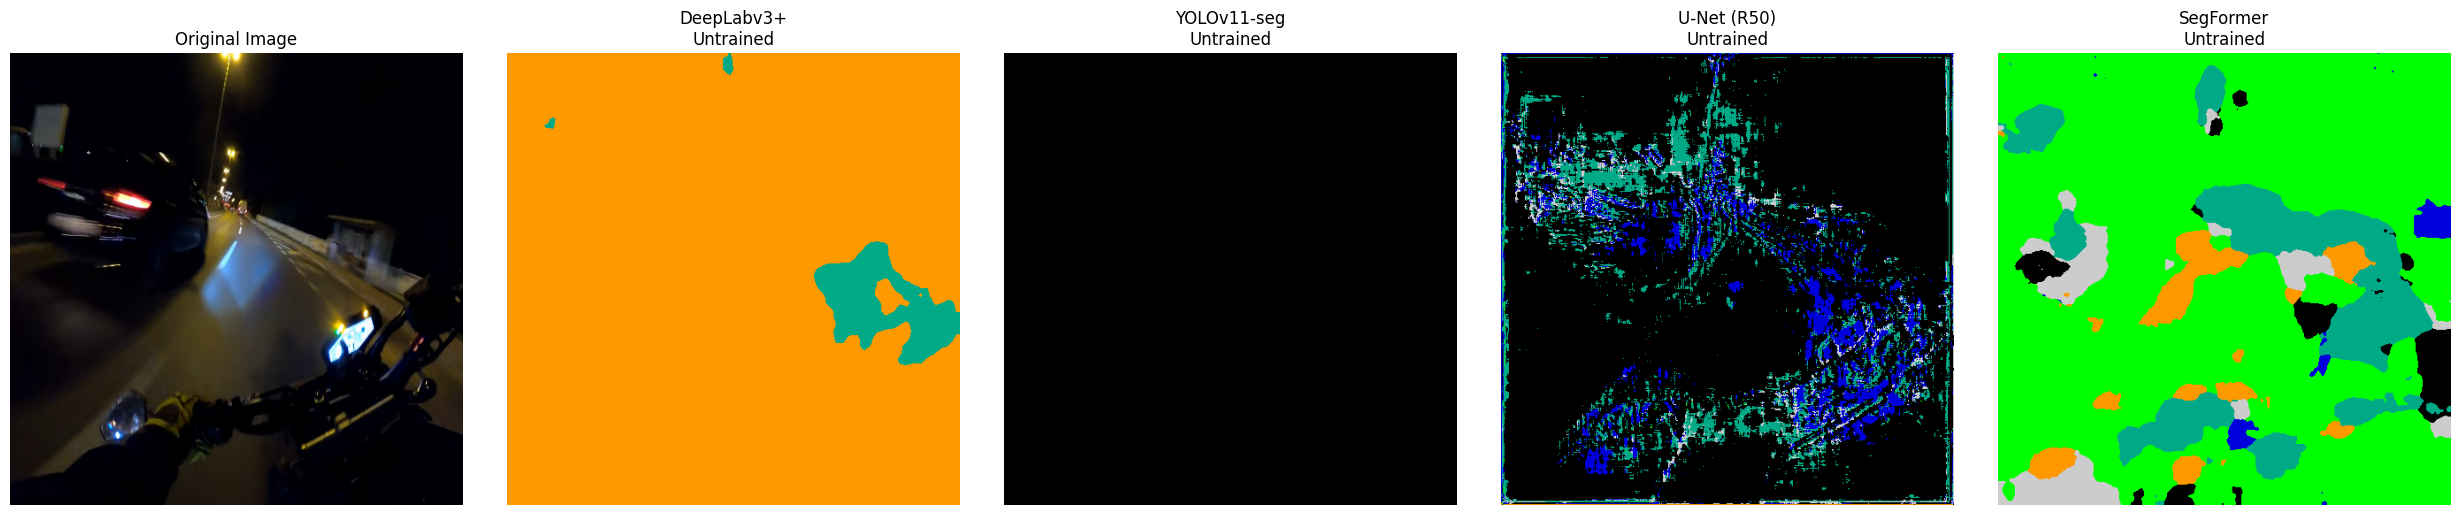

In [23]:
import torch.nn as nn

# --- [모델 1: DeepLabv3+ (ResNet50)] ---
model_dlv3 = deeplabv3_resnet50(weights='DEFAULT')
model_dlv3.classifier[4] = nn.Conv2d(model_dlv3.classifier[4].in_channels, NUM_CLASSES, 1)
model_dlv3.aux_classifier[4] = nn.Conv2d(model_dlv3.aux_classifier[4].in_channels, NUM_CLASSES, 1)
model_dlv3.to(device).eval()

# --- [모델 2: YOLOv11-seg] ---
model_yolo = YOLO('yolo11n-seg.pt') # Ultralytics

# --- [모델 3: U-Net (ResNet50)] ---
model_unet = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=NUM_CLASSES).to(device).eval()

# --- [모델 4: SegFormer (MiT-B0)] ---
model_segf = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", num_labels=NUM_CLASSES, ignore_mismatched_sizes=True).to(device).eval()

# 3. 통합 추론 (Inference)
with torch.no_grad():
    # DeepLabv3+
    out_dlv3 = model_dlv3(input_tensor)['out']
    pred_dlv3 = torch.argmax(out_dlv3, dim=1).squeeze(0).cpu().numpy()

    # YOLOv11 (내부 리사이징 포함)
    res_yolo = model_yolo(img1_RGB, imgsz=512, verbose=False)[0]
    if res_yolo.masks is not None:
        pred_yolo = torch.max(res_yolo.masks.data, dim=0)[0].cpu().numpy()
        pred_yolo = cv2.resize(pred_yolo, (512, 512), interpolation=cv2.INTER_NEAREST)
    else:
        pred_yolo = np.zeros((512, 512))

    # U-Net
    out_unet = model_unet(input_tensor)
    pred_unet = torch.argmax(out_unet, dim=1).squeeze(0).cpu().numpy()

    # SegFormer (Upsampling 필요)
    out_segf = model_segf(input_tensor).logits
    out_segf = F.interpolate(out_segf, size=(512, 512), mode='bilinear', align_corners=False)
    pred_segf = torch.argmax(out_segf, dim=1).squeeze(0).cpu().numpy()

# 4. 결과 시각화
models_info = [
    ("DeepLabv3+", pred_dlv3),
    ("YOLOv11-seg", pred_yolo),
    ("U-Net (R50)", pred_unet),
    ("SegFormer", pred_segf)
]

plt.figure(figsize=(25, 5))

# 원본
plt.subplot(1, 5, 1)
plt.imshow(cv2.resize(img1_RGB, (512, 512)))
plt.title("Original Image")
plt.axis('off')

# 각 모델 예측 결과
for i, (name, pred) in enumerate(models_info):
    plt.subplot(1, 5, i + 2)
    # nipy_spectral: 클래스 구분이 뚜렷한 컬러맵
    plt.imshow(pred, cmap='nipy_spectral', vmin=0, vmax=NUM_CLASSES-1)
    plt.title(f"{name}\nUntrained")
    plt.axis('off')

plt.tight_layout()
plt.show()